# Assignment 2: Detecting Linux system hacking activities Part B

#### Student Name: Soyeon Kim

## 3. Streaming application using Spark Structured Streaming

In this task, we will implement Spark Structured Streaming to consume the data from task 1
and perform predictive analytics. <br><br>

<strong>Important :
- In this task, use Spark Structured Streaming together with Spark SQL and ML
- You are also provided with a set of pre-trained pipeline models, one for
predicting attack in process data, another for predicting attack in memory data </strong>

Write a python program that achieves the following requirements. 

#### 1. SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone

In [1]:
#Import necessary libraries and initialize Spark Session
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from itertools import chain
from pyspark.ml.pipeline import PipelineModel
import time
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd #for visualization

# SparkConf
conf = SparkConf() \
    .setAppName("Assignment 2B") \
    .setMaster("local[2]")

# SparkSession
spark = SparkSession \
    .builder \
    .config(conf = conf) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .getOrCreate()

#### 2. From the Kafka producers in Task 1.1 and 1.2, ingest the streaming data into Spark Streaming for both process and memory activities

In [2]:
process_stream = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
  .option("subscribe", "Streaming_Linux_process") \
  .load()

memory_stream = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
  .option("subscribe", "Streaming_Linux_memory") \
  .load()

In [3]:
process_stream.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
memory_stream.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



#### 3. Then the streaming data format should be transformed into the proper formats following the metadata file schema for both process and memory, similar to assignment 2A

- The numeric values with extra spaces or “K” / “M” / “G” should be properly
transformed into their correct values
- The NICE value should also be restored based on the PRI values using their relationship 
    - Hint - There is a mapping between PRI (priority) and NICE, as long as the process is not yet finished during the last interval. For example,
        - PRI 100 maps to NICE -20
        - PRI 101 maps toNICE -19
        - …
        - PRI 139 maps to NICE 19
    - Hint - If the process is finished, PRI and NICE would both be 0.

In [5]:
# Converting the key/value from the kafka data stream to string
process_df = process_stream.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")
memory_df = memory_stream.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [6]:
#Define the schema for the structured datastream received
process_schema = ArrayType(StructType([       
    StructField("sequence", IntegerType(), True),
    StructField("machine", IntegerType(), True),
    StructField("PID", IntegerType(), True),
    StructField("TRUN", IntegerType(), True),
    StructField("TSLPI", IntegerType(), True),
    StructField("TSLPU", IntegerType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", IntegerType(), True),
    StructField("PRI", IntegerType(), True),
    StructField("RTPR", IntegerType(), True),
    StructField("CPUNR", IntegerType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", IntegerType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", DoubleType(), True),
    StructField("CMD", StringType(), True), 
    StructField("ts", IntegerType(), True)     
]))


memory_schema = ArrayType(StructType([      
    StructField("sequence", IntegerType(), True),
    StructField("machine", IntegerType(), True),         
    StructField("PID", IntegerType(), True),
    StructField("MINFLT", StringType(), True),
    StructField("MAJFLT", StringType(), True),
    StructField("VSTEXT", StringType(), True),
    StructField("VSIZE", DoubleType(), True),
    StructField("RSIZE", StringType(), True),
    StructField("VGROW", StringType(), True),
    StructField("RGROW", StringType(), True),
    StructField("MEM", DoubleType(), True),    
    StructField("CMD", StringType(), True),  
    StructField("ts", IntegerType(), True)    
]))

In [7]:
process_df = process_df.select(F.from_json(F.col("value").cast("string"), process_schema).alias('parsed_value'))
memory_df = memory_df.select(F.from_json(F.col("value").cast("string"), memory_schema).alias('parsed_value'))

# flatten nested columns
process_df = process_df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))   
memory_df = memory_df.select(F.explode(F.col("parsed_value")).alias('unnested_value'))

# format the schemas
process_df_formatted = process_df.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.TRUN").alias("TRUN"),
                    F.col("unnested_value.TSLPI").alias("TSLPI"),
                    F.col("unnested_value.TSLPU").alias("TSLPU"),
                    F.col("unnested_value.POLI").alias("POLI"),
                    F.col("unnested_value.NICE").alias("NICE"),
                    F.col("unnested_value.PRI").alias("PRI"),
                    F.col("unnested_value.RTPR").alias("RTPR"),
                    F.col("unnested_value.CPUNR").alias("CPUNR"),
                    F.col("unnested_value.Status").alias("Status"),
                    F.col("unnested_value.EXC").alias("EXC"),
                    F.col("unnested_value.State").alias("State"),
                    F.col("unnested_value.CPU").alias("CPU"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

memory_df_formatted = memory_df.select(
                    F.col("unnested_value.sequence").alias("sequence"),
                    F.col("unnested_value.machine").alias("machine"),
                    F.col("unnested_value.PID").alias("PID"),
                    F.col("unnested_value.MINFLT").alias("MINFLT"),
                    F.col("unnested_value.MAJFLT").alias("MAJFLT"),
                    F.col("unnested_value.VSTEXT").alias("VSTEXT"),
                    F.col("unnested_value.VSIZE").alias("VSIZE"),
                    F.col("unnested_value.RSIZE").alias("RSIZE"),
                    F.col("unnested_value.VGROW").alias("VGROW"),
                    F.col("unnested_value.RGROW").alias("RGROW"),
                    F.col("unnested_value.MEM").alias("MEM"),
                    F.col("unnested_value.CMD").alias("CMD"),
                    F.col("unnested_value.ts").alias("ts")
                )

In [8]:
process_df_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



In [9]:
memory_df_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: string (nullable = true)
 |-- MAJFLT: string (nullable = true)
 |-- VSTEXT: string (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: string (nullable = true)
 |-- VGROW: string (nullable = true)
 |-- RGROW: string (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



<li> The numeric values with extra spaces or “K” / “M” / “G” should be properly transformed into their correct values

In [10]:
memory_df_formatted = memory_df_formatted.withColumn("MINFLT", when(col('MINFLT').like("%K"), (regexp_replace('MINFLT', 'K', '').cast('double')*1000))\
                                .when(col('MINFLT').like("%M"), (regexp_replace('MINFLT', 'M', '').cast('double')*1000000))\
                                .when(col('MINFLT').like("%G"), (regexp_replace('MINFLT', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('MINFLT', ' ', '').cast('double'))))

memory_df_formatted = memory_df_formatted.withColumn("MAJFLT", when(col('MAJFLT').like("%K"), (regexp_replace('MAJFLT', 'K', '').cast('double')*1000))\
                                .when(col('MAJFLT').like("%M"), (regexp_replace('MAJFLT', 'M', '').cast('double')*1000000))\
                                .when(col('MAJFLT').like("%G"), (regexp_replace('MAJFLT', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('MAJFLT', ' ', '').cast('double'))))

memory_df_formatted = memory_df_formatted.withColumn("VSTEXT", when(col('VSTEXT').like("%K"), (regexp_replace('VSTEXT', 'K', '').cast('double')*1000))\
                                .when(col('VSTEXT').like("%M"), (regexp_replace('VSTEXT', 'M', '').cast('double')*1000000))\
                                .when(col('VSTEXT').like("%G"), (regexp_replace('VSTEXT', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('VSTEXT', ' ', '').cast('double'))))

memory_df_formatted = memory_df_formatted.withColumn("RSIZE", when(col('RSIZE').like("%K"), (regexp_replace('RSIZE', 'K', '').cast('double')*1000))\
                                .when(col('RSIZE').like("%M"), (regexp_replace('RSIZE', 'M', '').cast('double')*1000000))\
                                .when(col('RSIZE').like("%G"), (regexp_replace('RSIZE', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('RSIZE', ' ', '').cast('double'))))

memory_df_formatted = memory_df_formatted.withColumn("VGROW", when(col('VGROW').like("%K"), (regexp_replace('VGROW', 'K', '').cast('double')*1000))\
                                .when(col('VGROW').like("%M"), (regexp_replace('VGROW', 'M', '').cast('double')*1000000))\
                                .when(col('VGROW').like("%G"), (regexp_replace('VGROW', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('VGROW', ' ', '').cast('double'))))

memory_df_formatted = memory_df_formatted.withColumn("RGROW", when(col('RGROW').like("%K"), (regexp_replace('RGROW', 'K', '').cast('double')*1000))\
                                .when(col('RGROW').like("%M"), (regexp_replace('RGROW', 'M', '').cast('double')*1000000))\
                                .when(col('RGROW').like("%G"), (regexp_replace('RGROW', 'G', '').cast('double')*1000000000))\
                                .otherwise((regexp_replace('RGROW', ' ', '').cast('double'))))

In [11]:
memory_df_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)



<li> The NICE value should also be restored based on the PRI values using their relationship

|PRI | NICE |
|---|---|
|0 |0 |
|100 |-20 |
|109 |-11 |
|110 |-10 |
|120 |0 |
|121 |1 |
|130 |10 |
|139 |19 | 

Based on this data, we will change the value of the NICE column.<br>

https://stackoverflow.com/questions/50321549/map-values-in-a-dataframe-from-a-dictionary-using-pyspark/52015818

In [12]:
# Create a dictionary for mapping values
valmap = {0: 0, 100: -20, 109:-11, 110:-10, 120:0, 121:1, 130:10, 139:19}

# Replace the values of the 'NICE' column
mapping_expr = create_map([lit(x) for x in chain(*valmap.items())])
process_df_formatted = process_df_formatted.withColumn('NICE', mapping_expr[process_df_formatted['PRI']])

#### 4. For process and memory, respectively, create a new column “CMD_PID” concatenating “CMD” and “PID” columns, and a new column “event_time” as timestamp format based on the unix time in “ts” column 

- Allow 20-second tolerance for possible data delay on “event_time” using watermarking

In [13]:
# create a new column “CMD_PID” concatenating “CMD” and “PID”
process_df_formatted = process_df_formatted.withColumn('CMD_PID', F.concat(F.col('CMD'),F.lit('_'), F.col('PID')))
memory_df_formatted = memory_df_formatted.withColumn('CMD_PID', F.concat(F.col('CMD'),F.lit('_'), F.col('PID')))

In [14]:
process_df_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)



In [15]:
memory_df_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)



In [16]:
# create a new column “event_time” as timestamp format based on the unix time in “ts” column
process_df_formatted = process_df_formatted.withColumn("event_time", F.col("ts").cast(TimestampType()))
memory_df_formatted = memory_df_formatted.withColumn("event_time", F.col("ts").cast(TimestampType()))

In [17]:
process_df_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- TRUN: integer (nullable = true)
 |-- TSLPI: integer (nullable = true)
 |-- TSLPU: integer (nullable = true)
 |-- POLI: string (nullable = true)
 |-- NICE: integer (nullable = true)
 |-- PRI: integer (nullable = true)
 |-- RTPR: integer (nullable = true)
 |-- CPUNR: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- EXC: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- CPU: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)



In [18]:
memory_df_formatted.printSchema()

root
 |-- sequence: integer (nullable = true)
 |-- machine: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: double (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- ts: integer (nullable = true)
 |-- CMD_PID: string (nullable = true)
 |-- event_time: timestamp (nullable = true)



In [19]:
# Allow 20-second tolerance for possible data delay on “event_time” using watermarking
# Watermarking lets the engine automatically track the current event time in the data 
# and update the aggregate window and the states accordingly.
process_df_watermarking = process_df_formatted.withWatermark("event_time", "20 seconds")
memory_df_watermarking = memory_df_formatted.withWatermark("event_time", "20 seconds")

#### 5. Persist the transformed streaming data in parquet format for both process and memory 

- The process data should be stored in “process.parquet” in the same folder of your notebook, and the memory data should be stored in “memory.parquet” in the same folder of your notebook

In [20]:
# Write into parquet files the unsuccessful requests partitioned by status code
process_query_file_sink = process_df_watermarking.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "./process.parquet")\
        .option("checkpointLocation", "./process.parquet/checkpoint")\
        .start()

memory_query_file_sink = memory_df_watermarking.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "./memory.parquet")\
        .option("checkpointLocation", "./memory.parquet/checkpoint")\
        .start()

In [21]:
#Stop the file_sink query
process_query_file_sink.stop()
memory_query_file_sink.stop()

#### 6. Load the machine learning models given, and use the models to predict whether each process or memory streaming record is an attack event, respectively.

- The provided model is a generic model which uses all columns except “ts”, “machine”, “sequence". <font color = 'red'>Make sure you do NOT drop / rename any columns before prediction .

In [22]:
# The following codes are for unzipping the given zip files and save the outputs in the same forder

#import zipfile as zf

#process_files = zf.ZipFile("process_pipeline_model.zip", 'r')
#process_files.extractall('./process_pipeline_model')
#process_files.close()

#memory_files = zf.ZipFile("memory_pipeline_model.zip", 'r')
#memory_files.extractall('./memory_pipeline_model')
#memory_files.close()

In [23]:
# Load the machine learning models
process_model = PipelineModel.load("./process_pipeline_model/process_pipeline_model")
memory_model = PipelineModel.load("./memory_pipeline_model/memory_pipeline_model")

In [24]:
# predict whether each process streaming record is an attack event
process_prediction = process_model.transform(process_df_watermarking)

In [25]:
process_attack_query = process_prediction \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [26]:
process_attack_query.stop()

In [27]:
# predict whether memory streaming record is an attack event
memory_prediction = memory_model.transform(memory_df_watermarking)

In [28]:
memory_attack_query = memory_prediction \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [29]:
memory_attack_query.stop()

#### 7. Using the prediction result, and monitor the data following the requirements below

<strong>a.</strong> If any program in one machine is predicted as an attack in <strong>EITHER</strong> process
or memory activity prediction, it could be a false alarm or a potential attack.
Keep track of the approximate count of such events <strong>in every 2-min window</strong>
for each machine for process and memory, respectively, and write the stream
into Spark Memory sink using complete mode 

- Your aggregated result should include machine ID, the time window, and the counts
- Note that if there are more than one entries having the SAME “CMD_PID” in a 2-min window, get the approximate distinct count
    - For example, if two or more records of “atop” program with the exact same “CMD_PID” are predicted as an attack in the process between 2020-10-10 10:10:10 and 2020-10-10 10:11:09 , only need to count this “atop” program attack once.

<li> process activity

In [30]:
# https://stackoverflow.com/questions/37949494/how-to-count-occurrences-of-each-distinct-value-for-every-column-in-a-dataframe
process_windowedCounts = process_prediction \
    .filter(col("prediction")==1) \
    .groupBy("machine", window("event_time", "2 minutes"))\
    .agg(F.approx_count_distinct("CMD_PID").alias("count"))\
    .select("machine", "window", "count")

In [31]:
process_windowedCounts.printSchema()

root
 |-- machine: integer (nullable = true)
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- count: long (nullable = false)



In [32]:
#Change the output sink to "memory" and write output to the memory sink
process_query_7a = process_windowedCounts \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("process_query_7a") \
    .option("truncate", False) \
    .trigger(processingTime='5 seconds') \
    .start()

In [33]:
process_query_7a.stop()

<li> memory activity

In [34]:
memory_windowedCounts = memory_prediction \
    .filter(col("prediction")==1) \
    .groupBy("machine", window("event_time", "2 minutes"))\
    .agg(F.approx_count_distinct("CMD_PID").alias("count"))\
    .select("machine", "window", "count")

In [35]:
memory_windowedCounts.printSchema()

root
 |-- machine: integer (nullable = true)
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- count: long (nullable = false)



In [36]:
#Change the output sink to "memory" and write output to the memory sink
memory_query_7a = memory_windowedCounts \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("memory_query_7a") \
    .option("truncate", False) \
    .trigger(processingTime='5 seconds') \
    .start()

In [37]:
memory_query_7a.stop()

<strong>b.</strong> If a program in one machine, having the same “CMD” and “PID” in both
process and memory streaming data, is predicted as an attack in <strong>BOTH</strong>
process and memory activity prediction, then this is considered as an attack
event. Find the streaming events fulfilling the criteria, create a new column to
record the processing time(Processing time is usually different from the event time. It can serve other purposes in the further usage of the data, such as auditing.) and persist them in parquet.<br>
- Note the program with the same “CMD” and “PID” might not be generated at the exact same event time. If the difference between the event times in process and memory is less than 30 seconds and the program fulfills the criteria of matching “CMD” and “PID”, then you should include them for the above checking.
- If there are multiple entries fulfilling the above criteria in process or memory, do not remove the extra entries
- Persist the program’s relevant information (including process & memory data, process & memory’s event and processing timestamp, and prediction result) into parquet format with the name of “process_memory_attack.parquet”

In [38]:
# rename the columns before joining two activities' data
process_col_rename = list(map(lambda x: "process_"+ x, process_prediction.columns))
process_prediction_renamed = process_prediction.toDF(*process_col_rename)

memory_col_rename = list(map(lambda x: "memory_"+ x, memory_prediction.columns))
memory_prediction_renamed = memory_prediction.toDF(*memory_col_rename)

In [39]:
process_prediction_renamed.printSchema()

root
 |-- process_sequence: integer (nullable = true)
 |-- process_machine: integer (nullable = true)
 |-- process_PID: integer (nullable = true)
 |-- process_TRUN: integer (nullable = true)
 |-- process_TSLPI: integer (nullable = true)
 |-- process_TSLPU: integer (nullable = true)
 |-- process_POLI: string (nullable = true)
 |-- process_NICE: integer (nullable = true)
 |-- process_PRI: integer (nullable = true)
 |-- process_RTPR: integer (nullable = true)
 |-- process_CPUNR: integer (nullable = true)
 |-- process_Status: string (nullable = true)
 |-- process_EXC: integer (nullable = true)
 |-- process_State: string (nullable = true)
 |-- process_CPU: double (nullable = true)
 |-- process_CMD: string (nullable = true)
 |-- process_ts: integer (nullable = true)
 |-- process_CMD_PID: string (nullable = true)
 |-- process_event_time: timestamp (nullable = true)
 |-- process_POLI_idx: double (nullable = false)
 |-- process_Status_idx: double (nullable = false)
 |-- process_State_idx: doubl

In [40]:
memory_prediction_renamed.printSchema()

root
 |-- memory_sequence: integer (nullable = true)
 |-- memory_machine: integer (nullable = true)
 |-- memory_PID: integer (nullable = true)
 |-- memory_MINFLT: double (nullable = true)
 |-- memory_MAJFLT: double (nullable = true)
 |-- memory_VSTEXT: double (nullable = true)
 |-- memory_VSIZE: double (nullable = true)
 |-- memory_RSIZE: double (nullable = true)
 |-- memory_VGROW: double (nullable = true)
 |-- memory_RGROW: double (nullable = true)
 |-- memory_MEM: double (nullable = true)
 |-- memory_CMD: string (nullable = true)
 |-- memory_ts: integer (nullable = true)
 |-- memory_CMD_PID: string (nullable = true)
 |-- memory_event_time: timestamp (nullable = true)
 |-- memory_tmp_CMD: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- memory_CMD_vec: vector (nullable = true)
 |-- memory_features: vector (nullable = true)
 |-- memory_scaled_features: vector (nullable = true)
 |-- memory_rawPrediction: vector (nullable = true)
 |-- memory_probability: vecto

In [41]:
# join two dataframes
joined_df = process_prediction_renamed.join(memory_prediction_renamed, expr("process_CMD_PID == memory_CMD_PID"),"inner")\
            .select("*")

In [42]:
joined_df.printSchema()

root
 |-- process_sequence: integer (nullable = true)
 |-- process_machine: integer (nullable = true)
 |-- process_PID: integer (nullable = true)
 |-- process_TRUN: integer (nullable = true)
 |-- process_TSLPI: integer (nullable = true)
 |-- process_TSLPU: integer (nullable = true)
 |-- process_POLI: string (nullable = true)
 |-- process_NICE: integer (nullable = true)
 |-- process_PRI: integer (nullable = true)
 |-- process_RTPR: integer (nullable = true)
 |-- process_CPUNR: integer (nullable = true)
 |-- process_Status: string (nullable = true)
 |-- process_EXC: integer (nullable = true)
 |-- process_State: string (nullable = true)
 |-- process_CPU: double (nullable = true)
 |-- process_CMD: string (nullable = true)
 |-- process_ts: integer (nullable = true)
 |-- process_CMD_PID: string (nullable = true)
 |-- process_event_time: timestamp (nullable = true)
 |-- process_POLI_idx: double (nullable = false)
 |-- process_Status_idx: double (nullable = false)
 |-- process_State_idx: doubl

In [43]:
joined_windowedCounts = joined_df \
    .filter((col("process_prediction")==1)\
            &(col("memory_prediction")==1)\
            &(col("process_machine")==col("memory_machine"))\
            &(col("process_CMD_PID")==col("memory_CMD_PID"))) \
    .groupBy("process_machine", "memory_machine", window("process_event_time", "30 seconds"))\
    .agg(F.count("process_CMD_PID").alias("count"))

In [44]:
# create a new column to record the processing time
joined_windowedCounts_ts = joined_windowedCounts.withColumn("processing_time", current_timestamp())

In [45]:
joined_windowedCounts_ts.printSchema()

root
 |-- process_machine: integer (nullable = true)
 |-- memory_machine: integer (nullable = true)
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- count: long (nullable = false)
 |-- processing_time: timestamp (nullable = false)



In [46]:
# Write into parquet files the unsuccessful requests partitioned by status code
process_memory_attack_query_file_sink = joined_windowedCounts_ts.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "./process_memory_attack.parquet")\
        .option("checkpointLocation", "./process_memory_attack.parquet/checkpoint")\
        .start()

In [47]:
#Stop the file_sink query
process_memory_attack_query_file_sink.stop()

#### 8. Visualise the data in line charts for step 7a 

- For the count of suspect attacks for each machine in step 7a, use Spark SQL to query the data from Spark Memory sink, and prepare a line chart plot for showing the count of suspect attacks for each machine at each 2-min window from the start to the most recent, and refresh the plot every 10 minutes <br><br>
    - Hint - x-axis can be used to represent the timeline, while y-axis can be used to represent the count; each machine’s line data can be represented in different color legends

In [48]:
# add the end time to the previous 7a query
process_windowedCounts_time = process_prediction \
    .filter(col("prediction")==1) \
    .groupBy("machine", window("event_time", "2 minutes"))\
    .agg(F.approx_count_distinct("CMD_PID").alias("count"))\
    .select("machine", "window", "count", F.col("window.end").alias("window_end_time"))

In [49]:
process_query_8 = process_windowedCounts_time \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("process_query_8") \
    .option("truncate", False) \
    .trigger(processingTime='5 seconds') \
    .start()

In [50]:
# process_query_8.stop()

In [51]:
# add the end time to the previous 7a query
memory_windowedCounts_time = memory_prediction \
    .filter(col("prediction")==1) \
    .groupBy("machine", window("event_time", "2 minutes"))\
    .agg(F.approx_count_distinct("CMD_PID").alias("count"))\
    .select("machine", "window", "count", F.col("window.end").alias("window_end_time"))

In [52]:
memory_query_8 = memory_windowedCounts_time \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("memory_query_8") \
    .option("truncate", False) \
    .trigger(processingTime='5 seconds') \
    .start()

In [53]:
# memory_query_8.stop()

In [54]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.suptitle('< Suspect attacks streaming data visualization>') # giving figure a title
        fig.subplots_adjust(hspace=0.8, wspace=1.0)
        
        # process
        ax1 = fig.add_subplot(211) # adding the subplot axes to the given grid position
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Count')
        ax1.set_title('Process activity suspect attacks visualization')
              
        # memory    
        ax2 = fig.add_subplot(212) # adding the subplot axes to the given grid position
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Count')
        ax2.set_title('Memory activity suspect attacks visualization')
       
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas    
        
        return fig, ax1, ax2
    
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


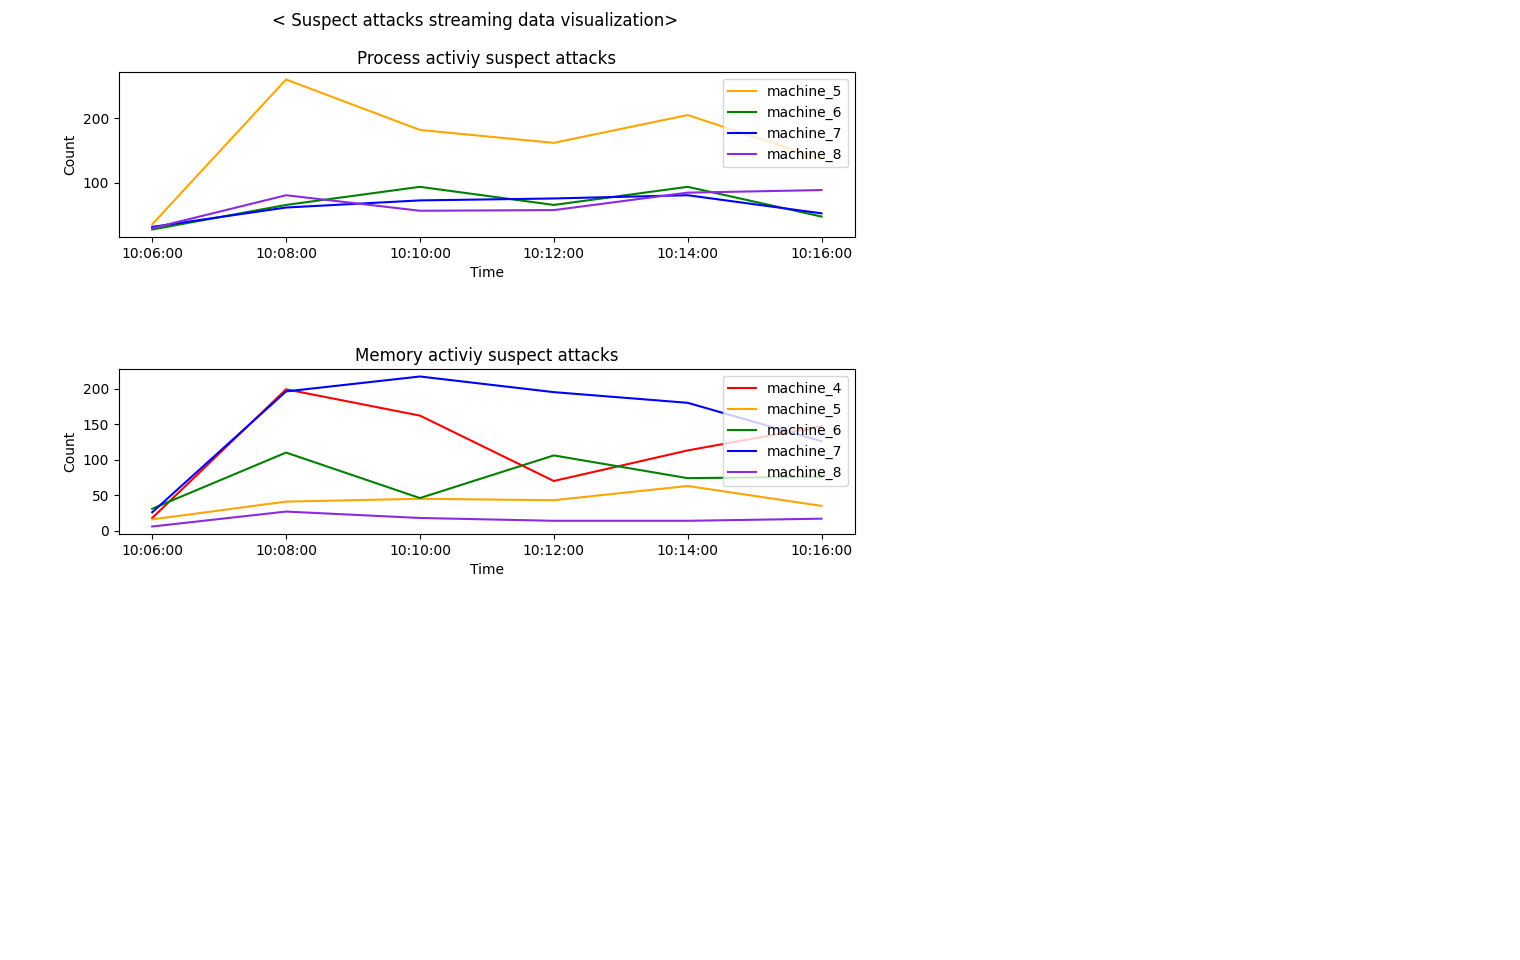

KeyboardInterrupt: 

In [55]:
%matplotlib notebook

fig, ax1, ax2 = init_plots()

while True:
    
    # process
    process_df = spark.sql("select * from process_query_8 order by window_end_time").toPandas()

    # x-axis = time
    #https://stackoverflow.com/questions/55632432/formatting-duration-as-hhmmss-and-write-to-pandas-dataframe-and-to-save-it-a
    process_df['window_end_time'] = pd.to_datetime(process_df['window_end_time']).dt.strftime("%H:%M:%S")
    process_x = process_df.loc[process_df['machine']==5, 'window_end_time'].tolist()

    # y-axis = count
    # there is no machine 4 in process query
    process_y5 = process_df.loc[process_df['machine']==5, 'count'].tolist()
    process_y6 = process_df.loc[process_df['machine']==6, 'count'].tolist()
    process_y7 = process_df.loc[process_df['machine']==7, 'count'].tolist()
    process_y8 = process_df.loc[process_df['machine']==8, 'count'].tolist()

    ax1.clear()               
    ax1.plot(process_x, process_y5, color = 'orange', label='machine_5')
    ax1.plot(process_x, process_y6, color = 'green', label='machine_6')
    ax1.plot(process_x, process_y7, color = 'blue', label='machine_7')
    ax1.plot(process_x, process_y8, color = 'blueviolet', label='machine_8')
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Count')
    ax1.legend(loc="upper right")
    ax1.set_title('Process activiy suspect attacks') 
    
    # memory
    memory_df = spark.sql("select * from memory_query_8 order by window_end_time").toPandas()
    
    # x-axis = time
    memory_df['window_end_time'] = pd.to_datetime(memory_df['window_end_time']).dt.strftime("%H:%M:%S")
    memory_x = memory_df.loc[memory_df['machine']==4, 'window_end_time'].tolist()
    
    # y-axis = count
    memory_y4 = memory_df.loc[memory_df['machine']==4, 'count'].tolist()
    memory_y5 = memory_df.loc[memory_df['machine']==5, 'count'].tolist()
    memory_y6 = memory_df.loc[memory_df['machine']==6, 'count'].tolist()
    memory_y7 = memory_df.loc[memory_df['machine']==7, 'count'].tolist()
    memory_y8 = memory_df.loc[memory_df['machine']==8, 'count'].tolist()

    ax2.clear()
    ax2.plot(memory_x, memory_y4, color = 'red', label='machine_4')                
    ax2.plot(memory_x, memory_y5, color = 'orange', label='machine_5')
    ax2.plot(memory_x, memory_y6, color = 'green', label='machine_6')
    ax2.plot(memory_x, memory_y7, color = 'blue', label='machine_7')
    ax2.plot(memory_x, memory_y8, color = 'blueviolet', label='machine_8')    
            
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Count')
    ax2.legend(loc="upper right")
    ax2.set_title('Memory activiy suspect attacks')
    
    fig.canvas.draw()
    
    # refresh the plot every 10 minutes (600 secs)
    time.sleep(600)